## Modèle

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


On va prédire les prix pour Amazon.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.models import load_model
%matplotlib inline
#from notify_run import Notify # pour m'envoyer des notification

C:\Users\ouizb\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ouizb\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ouizb\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ouizb\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

In [3]:
#notify = Notify()
#notify.register()

### Importation des données

In [4]:
def get_data(symbol):
    tickerData = yf.Ticker(symbol)
    data = tickerData.history(period='1d', start='2010-10-1', end="2020-9-29")
    data['companies'] = symbol
    data.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
    return data



In [5]:
msft = get_data("MSFT")
amzn = get_data("AMZN")
goog = get_data("GOOG")

In [6]:
msft.head()

,Open,High,Low,Close,Volume,companies
Date,,,,,,
2010-09-30,19.50,19.67,19.30,19.40,61262700,MSFT
2010-10-01,19.62,19.66,19.25,19.32,62672300,MSFT
2010-10-04,18.98,19.01,18.84,18.94,98143400,MSFT
2010-10-05,19.06,19.37,18.94,19.29,78152900,MSFT
2010-10-06,19.27,19.44,19.12,19.36,50489700,MSFT


# Rassembler les 3 sociétés dans le meme dataframe 

In [7]:

company_list = [msft, amzn, goog]

    
df_concat = pd.concat(company_list, axis=0)
    
df_concat.head()

,Open,High,Low,Close,Volume,companies
Date,,,,,,
2010-09-30,19.50,19.67,19.30,19.40,61262700,MSFT
2010-10-01,19.62,19.66,19.25,19.32,62672300,MSFT
2010-10-04,18.98,19.01,18.84,18.94,98143400,MSFT
2010-10-05,19.06,19.37,18.94,19.29,78152900,MSFT
2010-10-06,19.27,19.44,19.12,19.36,50489700,MSFT


In [8]:
df_concat.companies.unique()

array(['MSFT', 'AMZN', 'GOOG'], dtype=object)

# Split data 

In [11]:
def split_data(df, symbol):
    data = df.filter(['Close']).loc[df['companies']== symbol]
    dataset = data.values.reshape(-1, 1)
    training_data_len = int(np.ceil(len(dataset) * .8 ))
    print(f'Longueur du data: {training_data_len}')
    print('================================================')
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data= scaler.fit_transform(dataset)
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    return x_train, y_train, x_test, y_test

# Fonction LSTM 

In [17]:
def algo_lstm(x_train, y_train, x_test, y_test, symbol):
    scaler = MinMaxScaler(feature_range=(0,1))
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences= False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(x_train, y_train, batch_size=25, epochs=30, validation_split=0.1)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print('================================================')
    print(f'RMSE: {rmse}')
    print('================================================')
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16,8))
    plt.title('Prédictions vs. valeurs réeles')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Valeurs actuelles', 'Prédictions'], loc='lower right')
    plt.show()
    print('================================================')
    print(valid)
    #modelFileName = 'model_lstm.h5'
    #model.save(modelFileName) # saves the trained model
    #print("Model saved.")
    notify.send('It\'s done!')

    return model



# Prédiction du Prix du lendemain (le 29/09/2020)

In [18]:
def predict_price(symbol):
    tickerData = yf.Ticker(symbol)
    df = tickerData.history(period='1d', start='2010-10-1', end="2020-9-30")
    new_df = df.filter(['Close'])
    last_60_days = new_df[-60:].values
    last_60_days_scaled = scaler.transform(last_60_days)
    X_test = []
    X_test.append(last_60_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    print(f'Prix prédit: {pred_price}')

    actual_price = tickerData.history(period='1d', start="2020-9-29", end="2020-9-30")
    actual_price = actual_price.Close.values
    actual_price = np.array(actual_price)
    print(f'Prix réel: {actual_price}')
    return pred_price, actual_price

# LSTM Microsft

In [19]:
x_train, y_train, x_test, y_test = split_data(df_concat, "MSFT")

Longueur du data: 2013


Epoch 1/30
71/71 [==============================] - 10s 136ms/step - loss: 9.7075e-04 - val_loss: 1.1693e-04
Epoch 2/30
71/71 [==============================] - 6s 91ms/step - loss: 3.0917e-05 - val_loss: 9.6499e-05
Epoch 3/30
71/71 [==============================] - 7s 93ms/step - loss: 3.1430e-05 - val_loss: 9.7966e-05
Epoch 4/30
71/71 [==============================] - 6s 88ms/step - loss: 3.1494e-05 - val_loss: 1.3542e-04
Epoch 5/30
71/71 [==============================] - 8s 117ms/step - loss: 3.0889e-05 - val_loss: 9.3403e-05
Epoch 6/30
71/71 [==============================] - 8s 106ms/step - loss: 2.8506e-05 - val_loss: 9.0495e-05
Epoch 7/30
71/71 [==============================] - 8s 113ms/step - loss: 3.0495e-05 - val_loss: 1.1254e-04
Epoch 8/30
71/71 [==============================] - 8s 109ms/step - loss: 2.8684e-05 - val_loss: 1.3422e-04
Epoch 9/30
71/71 [==============================] - 6s 85ms/step - loss: 2.7872e-05 - val_loss: 1.4326e-04
Epoch 10/30
71/71 [============

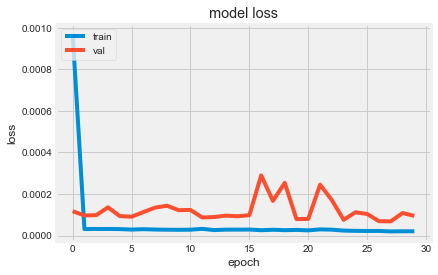

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [20]:
model = algo_lstm(x_train, y_train, x_test, y_test, "MSFT")

In [ ]:
predict_price("MSFT")

# LSTM Google 

In [ ]:
x_train, y_train, x_test, y_test = split_data(df_concat, "GOOG")
model = algo_lstm(x_train, y_train, x_test, y_test, "GOOG")

In [ ]:
predict_price("GOOG")

# LSTM Amazon

In [ ]:
x_train, y_train, x_test, y_test = split_data(df_concat, "AMZN")
model = algo_lstm(x_train, y_train, x_test, y_test, "AMZN")

In [ ]:
predict_price("AMZN")